In [4]:
import xarray as xr

In [5]:
pip install dask

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
import dask

In [7]:
ds = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/aggregations/g/ds633.1/2/TP',
                     chunks={'time':'500MB'})

variables = ['Total_column_water_vapour_surface_Mixed_intervals_Average',
        'Sea_surface_temperature_surface_Mixed_intervals_Average']
#select the two needed variables every 4th point to get 1 degree resolution
ds = ds[variables].sel(lat=slice(65, -65, 4), lon=slice(120, 300, 4))

In [8]:
ds

<xarray.Dataset> Size: 97MB
Dimensions:                                                    (time: 516,
                                                                lat: 130,
                                                                lon: 181)
Coordinates:
  * lat                                                        (lat) float32 520B ...
  * lon                                                        (lon) float32 724B ...
  * time                                                       (time) datetime64[ns] 4kB ...
    reftime                                                    (time) datetime64[ns] 4kB dask.array<chunksize=(516,), meta=np.ndarray>
Data variables:
    Total_column_water_vapour_surface_Mixed_intervals_Average  (time, lat, lon) float32 49MB dask.array<chunksize=(120, 130, 181), meta=np.ndarray>
    Sea_surface_temperature_surface_Mixed_intervals_Average    (time, lat, lon) float32 49MB dask.array<chunksize=(120, 130, 181), meta=np.ndarray>
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

In [9]:
ds.to_netcdf('raw_data.nc')

In [10]:
pip install matplotlib cartopy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load the dataset (assuming ds is already your xarray.Dataset)
ds = xr.open_dataset('raw_data.nc')

In [12]:
ds

<xarray.Dataset> Size: 97MB
Dimensions:                                                    (time: 516,
                                                                lat: 130,
                                                                lon: 181)
Coordinates:
  * lat                                                        (lat) float32 520B ...
  * lon                                                        (lon) float32 724B ...
  * time                                                       (time) datetime64[ns] 4kB ...
    reftime                                                    (time) datetime64[ns] 4kB ...
Data variables:
    Total_column_water_vapour_surface_Mixed_intervals_Average  (time, lat, lon) float32 49MB ...
    Sea_surface_temperature_surface_Mixed_intervals_Average    (time, lat, lon) float32 49MB ...
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

In [13]:
# Calculate the mean SST and mean TCWV over the entire period
mean_sst = ds['Sea_surface_temperature_surface_Mixed_intervals_Average'].mean(dim='time')
mean_tcwv = ds['Total_column_water_vapour_surface_Mixed_intervals_Average'].mean(dim='time')

In [14]:
mean_sst

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             lat: 130,
                                                                             lon: 181)> Size: 94kB
array([[      nan,       nan,       nan, ..., 272.62515, 272.71667,
        272.82245],
       [      nan,       nan,       nan, ..., 272.8599 , 273.0407 ,
        273.5661 ],
       [      nan,       nan,       nan, ..., 273.17636, 273.8434 ,
        274.68085],
       ...,
       [272.72824, 272.72784, 272.75504, ..., 272.98932, 272.9935 ,
        272.83612],
       [272.47736, 272.5224 , 272.54202, ..., 272.65787, 272.75925,
        272.2297 ],
       [272.1153 , 272.15176, 272.16583, ..., 272.13876, 271.73523,
              nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 520B 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 724B 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0

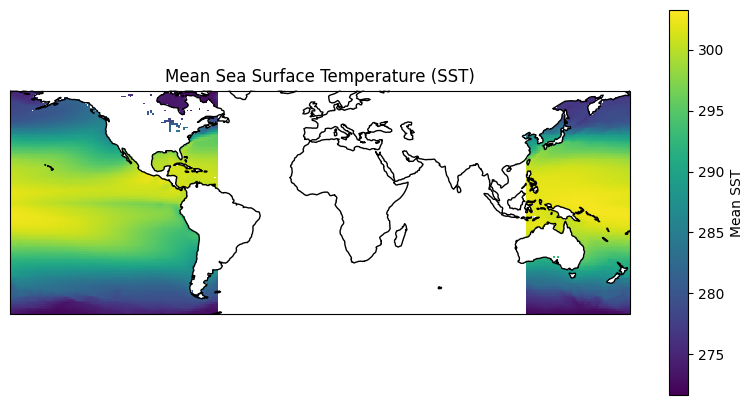

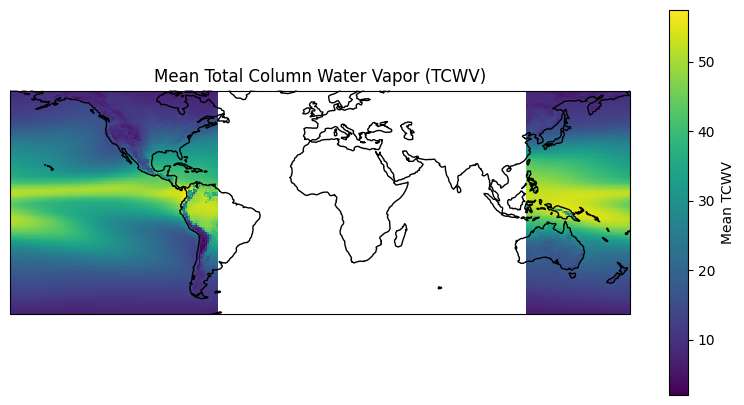

In [15]:
# Mean SST plot
fig1, ax1 = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax1.coastlines()  # Adds coastlines
mean_sst.plot(ax=ax1, transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Mean SST'})
ax1.set_title('Mean Sea Surface Temperature (SST)')
plt.show()

# Mean TCWV plot
fig2, ax2 = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
ax2.coastlines()  # Adds coastlines
mean_tcwv.plot(ax=ax2, transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Mean TCWV'})
ax2.set_title('Mean Total Column Water Vapor (TCWV)')
plt.show()

In [16]:
#DESEASONING

import numpy as np

# Assuming 'sst' is the variable name for Sea Surface Temperature in your dataset
sst = ds['Sea_surface_temperature_surface_Mixed_intervals_Average']

climatology = sst.groupby('time.month').mean('time')
anomalies = sst.groupby('time.month') - climatology

In [17]:
#DETRENDING

# Define the polynomial detrending function
def detrend_dim(da, dim, deg=1):
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# Apply a rolling mean to smooth the anomalies before detrending
smoothed_anomalies = anomalies.rolling(time=7, center=True).mean('time')

# Now, apply the polynomial detrending
detrended_anomalies = detrend_dim(smoothed_anomalies, 'time', 1)

In [18]:
# STANDARDIZING the anomalies
mean_anomalies = detrended_anomalies.mean('time', skipna=True)
std_anomalies = detrended_anomalies.std('time', skipna=True)
standardized_anomalies = (detrended_anomalies - mean_anomalies) / std_anomalies

# The standardized_anomalies xarray DataArray now contains the standardized SST anomalies


In [19]:
# EOR CALCULATION
ystr = 1979
yend = 2021

# == seasonal mean
anomalies_S = anomalies.rolling(time=3, center=True).mean('time')
anomalies_DJF=anomalies_S.sel(time=slice(f'{ystr}-02-01',f'{yend}-12-31',12))
print(anomalies_DJF)

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 43,
                                                                             lat: 130,
                                                                             lon: 181)> Size: 4MB
array([[[            nan,             nan,             nan, ...,
          2.03450527e-05, -2.07519531e-03, -1.30106611e-02],
        [            nan,             nan,             nan, ...,
         -1.94295251e-03, -6.64265966e-03,  2.27478027e-01],
        [            nan,             nan,             nan, ...,
          2.36409511e-02,  3.51643890e-01,  6.02325439e-01],
        ...,
        [-2.47253418e-01, -3.72589111e-01, -3.58632416e-01, ...,
         -6.01908386e-01, -4.34000641e-01, -2.98319489e-01],
        [-7.35961914e-01, -7.44252503e-01, -7.85044372e-01, ...,
         -5.33152282e-01, -3.14280182e-01,  1.06241859e-01],
       

In [20]:
# -- EOF --
anomalies_DJF=detrend_dim(anomalies_DJF,'time',1)
anomalies_DJF = anomalies_DJF.sortby("lat", ascending=True)
clat = anomalies_DJF['lat'].astype(np.float64)
clat = np.sqrt(np.cos(np.deg2rad(clat)))

In [21]:
# wanm = anomalies_DJF 
# wanm = anomalies_DJF * clat
# wanm.attrs = anomalies_DJF.attrs
# wanm.attrs['long_name'] = 'Wgt: ' + wanm.attrs['long_name']

# Check if 'long_name' attribute exists, if not assign a default value
if 'long_name' not in anomalies_DJF.attrs:
    anomalies_DJF.attrs['long_name'] = 'Sea Surface Temperature Anomalies'

wanm = anomalies_DJF * clat

# Now safely modify the 'long_name' attribute
wanm.attrs['long_name'] = 'Weighted ' + anomalies_DJF.attrs['long_name']
print(wanm)

<xarray.DataArray (time: 43, lat: 130, lon: 181)> Size: 8MB
array([[[-3.97641990e-01, -3.89196234e-01, -3.90890392e-01, ...,
          4.03371215e-01,  2.66568715e-01,             nan],
        [-4.00226301e-01, -4.05486703e-01, -4.19324361e-01, ...,
         -7.77889788e-02, -1.62864626e-02,  4.65096368e-01],
        [-1.87883321e-01, -3.25797922e-01, -2.91254076e-01, ...,
         -3.05642508e-01, -2.92121311e-01, -2.14875511e-01],
        ...,
        [            nan,             nan,             nan, ...,
          2.09947044e-02,  2.91298960e-01,  7.42330700e-01],
        [            nan,             nan,             nan, ...,
         -3.20783667e-04,  1.45674759e-03,  1.81768690e-01],
        [            nan,             nan,             nan, ...,
          3.22461575e-05,  3.01222432e-04, -8.91046269e-04]],

       [[ 1.12245550e-01,  9.79861180e-02,  1.04501577e-01, ...,
          2.78364783e-01,  2.81939992e-01,             nan],
        [-8.29399100e-02, -7.96969593e-02, 

In [22]:
latS = -65.
latN = 65.
lonW = 120.
lonE = 300

neof = 5

In [23]:
lon = wanm['lon']
if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
   wanm=wanm.assign_coords(lon=( (lon + 180) % 360 - 180) )
   wanm = wanm.sortby("lon")
   print(' change longitude ')
 
print(wanm) 

<xarray.DataArray (time: 43, lat: 130, lon: 181)> Size: 8MB
array([[[-3.97641990e-01, -3.89196234e-01, -3.90890392e-01, ...,
          4.03371215e-01,  2.66568715e-01,             nan],
        [-4.00226301e-01, -4.05486703e-01, -4.19324361e-01, ...,
         -7.77889788e-02, -1.62864626e-02,  4.65096368e-01],
        [-1.87883321e-01, -3.25797922e-01, -2.91254076e-01, ...,
         -3.05642508e-01, -2.92121311e-01, -2.14875511e-01],
        ...,
        [            nan,             nan,             nan, ...,
          2.09947044e-02,  2.91298960e-01,  7.42330700e-01],
        [            nan,             nan,             nan, ...,
         -3.20783667e-04,  1.45674759e-03,  1.81768690e-01],
        [            nan,             nan,             nan, ...,
          3.22461575e-05,  3.01222432e-04, -8.91046269e-04]],

       [[ 1.12245550e-01,  9.79861180e-02,  1.04501577e-01, ...,
          2.78364783e-01,  2.81939992e-01,             nan],
        [-8.29399100e-02, -7.96969593e-02, 

In [24]:
xw = wanm.sel(lat=slice(latS, latN), lon=slice(lonW, lonE))
xw_anm = xw.transpose('time', 'lat', 'lon')
print(xw_anm)

<xarray.DataArray (time: 43, lat: 130, lon: 181)> Size: 8MB
array([[[-3.97641990e-01, -3.89196234e-01, -3.90890392e-01, ...,
          4.03371215e-01,  2.66568715e-01,             nan],
        [-4.00226301e-01, -4.05486703e-01, -4.19324361e-01, ...,
         -7.77889788e-02, -1.62864626e-02,  4.65096368e-01],
        [-1.87883321e-01, -3.25797922e-01, -2.91254076e-01, ...,
         -3.05642508e-01, -2.92121311e-01, -2.14875511e-01],
        ...,
        [            nan,             nan,             nan, ...,
          2.09947044e-02,  2.91298960e-01,  7.42330700e-01],
        [            nan,             nan,             nan, ...,
         -3.20783667e-04,  1.45674759e-03,  1.81768690e-01],
        [            nan,             nan,             nan, ...,
          3.22461575e-05,  3.01222432e-04, -8.91046269e-04]],

       [[ 1.12245550e-01,  9.79861180e-02,  1.04501577e-01, ...,
          2.78364783e-01,  2.81939992e-01,             nan],
        [-8.29399100e-02, -7.96969593e-02, 

In [25]:
pip install geocat-comp geocat-viz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [27]:
import cartopy.feature as cfeature

import matplotlib.patheffects as PathEffects

from scipy import stats

import geocat.viz.util as gvutil
import cmaps

import geocat.viz as gv
from geocat.comp import eofunc_eofs, eofunc_pcs, month_to_season

eofs = eofunc_eofs(xw_anm.data, neofs=neof, meta=True)
pcs = eofunc_pcs(xw_anm.data, npcs=neof, meta=True)
pcs = pcs / pcs.std(dim='time')
pcs['time']=anomalies_DJF['time']
pcs.attrs['varianceFraction'] = eofs.attrs['varianceFraction']
print(pcs)

<xarray.DataArray 'pcs' (pc: 5, time: 43)> Size: 2kB
array([[-0.21278226,  0.33146598, -0.56562157, -0.23803543,  2.43816408,
        -0.23183891, -1.1123813 , -0.6099727 ,  1.04522181,  0.29515714,
        -1.79733321, -0.24311599,  0.03960112,  1.40144063,  0.70199572,
         0.12081062,  0.64949678, -0.5959039 , -0.45576841,  2.40796761,
        -1.51646396, -1.47691768, -0.46689311, -0.4263541 ,  0.88786962,
         0.11953226,  0.36819589, -0.58388142,  0.34427463, -1.51556813,
        -0.95142162,  1.09858851, -1.65723142, -0.70754991, -0.07869547,
         0.04352743,  0.82366396,  2.08469925,  0.44612605, -0.61513571,
         0.72841988,  0.55197387, -0.86932663],
       [-0.3052001 , -0.60516225, -0.78128601, -0.44464865,  2.00122384,
         0.06961563, -0.32313184, -1.19941949,  0.03548049,  0.64982458,
         0.77137117, -0.24279827, -1.56715472,  0.54838823, -0.31971193,
        -0.79105992, -0.08866033, -1.12520968, -1.01732221,  1.84285139,
         1.84176117,  1

In [28]:
evec = xr.DataArray(data=eofs, dims=('eof','lat','lon'),
    coords = {'eof': np.arange(0,neof), 'lat': xw['lat'], 'lon': xw['lon']} )
print(evec)

<xarray.DataArray 'eofs' (eof: 5, lat: 130, lon: 181)> Size: 941kB
array([[[ 1.51637544e-03,  1.15762515e-03,  1.00001140e-03, ...,
         -7.83256659e-04, -7.36844106e-04,             nan],
        [ 1.64971240e-03,  1.21515885e-03,  1.05703943e-03, ...,
         -1.74912830e-03, -1.23590984e-03, -1.41336577e-03],
        [ 1.37645143e-03,  1.57687479e-03,  1.55174705e-03, ...,
         -2.78455174e-03, -2.28174649e-03, -1.90013706e-03],
        ...,
        [            nan,             nan,             nan, ...,
         -2.24519128e-04, -9.02225327e-04, -1.32720956e-03],
        [            nan,             nan,             nan, ...,
         -4.29145228e-05, -2.18144750e-04, -8.71324379e-04],
        [            nan,             nan,             nan, ...,
         -2.49217199e-06, -4.60328530e-05, -1.96267552e-04]],

       [[-1.31008939e-03, -1.32717388e-03, -1.25809195e-03, ...,
         -7.58704601e-04, -7.24130349e-04,             nan],
        [-7.07585605e-05, -7.5194780

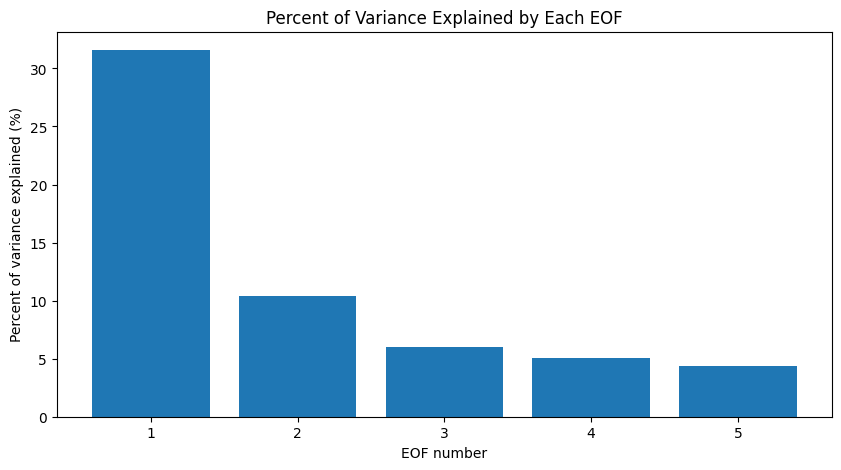

In [54]:
import matplotlib.pyplot as plt

# Get the variance fraction for the available EOFs (assuming eofs is the result from eofunc_eofs)
variance_fraction = eofs.attrs['varianceFraction']
eof_numbers = np.arange(1, len(variance_fraction) + 1)  # Adjust this if you have fewer than 10 EOFs

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(eof_numbers, variance_fraction * 100)  # Convert to percentage
plt.xlabel('EOF number')
plt.ylabel('Percent of variance explained (%)')
plt.title('Percent of Variance Explained by Each EOF')
plt.xticks(eof_numbers)
plt.show()

In [29]:
# Correlation & Regression
cor1 = xr.corr(pcs[0,:], anomalies_DJF, dim="time")
cor2 = xr.corr(pcs[1,:], anomalies_DJF, dim="time")
cor3 = xr.corr(pcs[2,:], anomalies_DJF, dim="time")
cor4 = xr.corr(pcs[3,:], anomalies_DJF, dim="time")
cor5 = xr.corr(pcs[4,:], anomalies_DJF, dim="time")

eg1 = xr.cov(pcs[0,:], anomalies_DJF, dim="time")/pcs[0,:].var(dim='time',skipna=True).values
eg2 = xr.cov(pcs[0,:], anomalies_DJF, dim="time")/pcs[0,:].var(dim='time',skipna=True).values
eg3 = xr.cov(pcs[0,:], anomalies_DJF, dim="time")/pcs[0,:].var(dim='time',skipna=True).values
eg4 = xr.cov(pcs[0,:], anomalies_DJF, dim="time")/pcs[0,:].var(dim='time',skipna=True).values
eg5 = xr.cov(pcs[0,:], anomalies_DJF, dim="time")/pcs[0,:].var(dim='time',skipna=True).values

In [33]:
pip install geocat-comp geocat-viz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [34]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt

# import geocat.datafiles as gdf
import geocat.viz as gv

In [36]:
import cmaps

In [39]:
# -- figure plot

def makefig(dat, ieof, grid_space):
  # Fix the artifact of not-shown-data around 0 and 360-degree longitudes
  # Generate axes using Cartopy to draw coastlines
  ax = fig.add_subplot(grid_space,
          projection=ccrs.PlateCarree(central_longitude=180))
#          projection=ccrs.Robinson(central_longitude=210))
  ax.coastlines(linewidth=0.5, alpha=0.6)
  
  gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  draw_labels=True,
                  dms=False,
                  x_inline=False,
                  y_inline=False,
                  linewidth=1,
                  linestyle='dotted',
                  color="black",
                  alpha=0.3)
  gl.top_labels = False
  gl.right_labels = False
  gl.rotate_labels = False

  # Use geocat.viz.util convenience function to add minor and major tick lines
  gvutil.add_major_minor_ticks(ax, labelsize=10)
  
  # Use geocat.viz.util convenience function to make latitude, longitude tick labels
  gvutil.add_lat_lon_ticklabels(ax)

  newcmp = cmaps.ncl_default

    # Define dictionary for kwargs
  kwargs = dict(
    vmin = -0.06,
    vmax = 0.06,
    levels = 21,
    #colors=color_list,
    add_colorbar=False,  # allow for colorbar specification later
    transform=ccrs.PlateCarree(),  # ds projection
  )
  
  # Contouf-plot U data (for filled contours)
  fillplot = dat[ieof,:,:].plot.contourf(ax=ax,  **kwargs)

  # Draw map features on top of filled contour
  ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
  ax.add_feature(cfeature.COASTLINE, edgecolor='gray', linewidth=0.5, zorder=1)
  
  # Use geocat.viz.util convenience function to add titles to left and right of the plot axis.
  gvutil.set_titles_and_labels(ax,
                             lefttitle=f'EOF{ieof+1} pattern',
                             lefttitlefontsize=12,
                             righttitle='',
                             righttitlefontsize=12,
                             maintitle='',
                             xlabel="",
                             ylabel="")

  return ax, fillplot




def make_bar_plot(dataset, ieof, grid_space):
    years = list(dataset.time.dt.year)
    values = list(dataset[ieof,:].values)
    colors = ['blue' if val < 0 else 'red' for val in values]

    ax = fig.add_subplot(grid_space)

    ax.bar(years,
           values,
           color=colors,
           width=1.0,
           edgecolor='black',
           linewidth=0.5)

    # Use geocat.viz.util convenience function to add minor and major tick lines
    gvutil.add_major_minor_ticks(ax,
                                 x_minor_per_major=5,
                                 y_minor_per_major=5,
                                 labelsize=10)

    # Use geocat.viz.util convenience function to set axes tick values
    gvutil.set_axes_limits_and_ticks(ax,
                                     xticks=np.linspace(1980, 2020, 5),
                                     xlim=[1979.5, 2020.5],
                                     ylim=[-3.0, 3.5])

    pct = dataset.attrs['varianceFraction'].values[ieof] * 100
    print(pct)
    gvutil.set_titles_and_labels(ax,
                             lefttitle=f'PC{ieof+1} (normalized)',
                             lefttitlefontsize=12,
                             righttitle=f'{pct:.1f}%',
                             righttitlefontsize=12,
                             xlabel="Year",
                             ylabel="",
                             labelfontsize=10 )
    return ax

Accessing grid location: GridSpec(4, 5)[0:2, 0:1]
31.581691658477624
10.417254442801049
6.04102453833905
5.087252126425076
4.4025641899915895


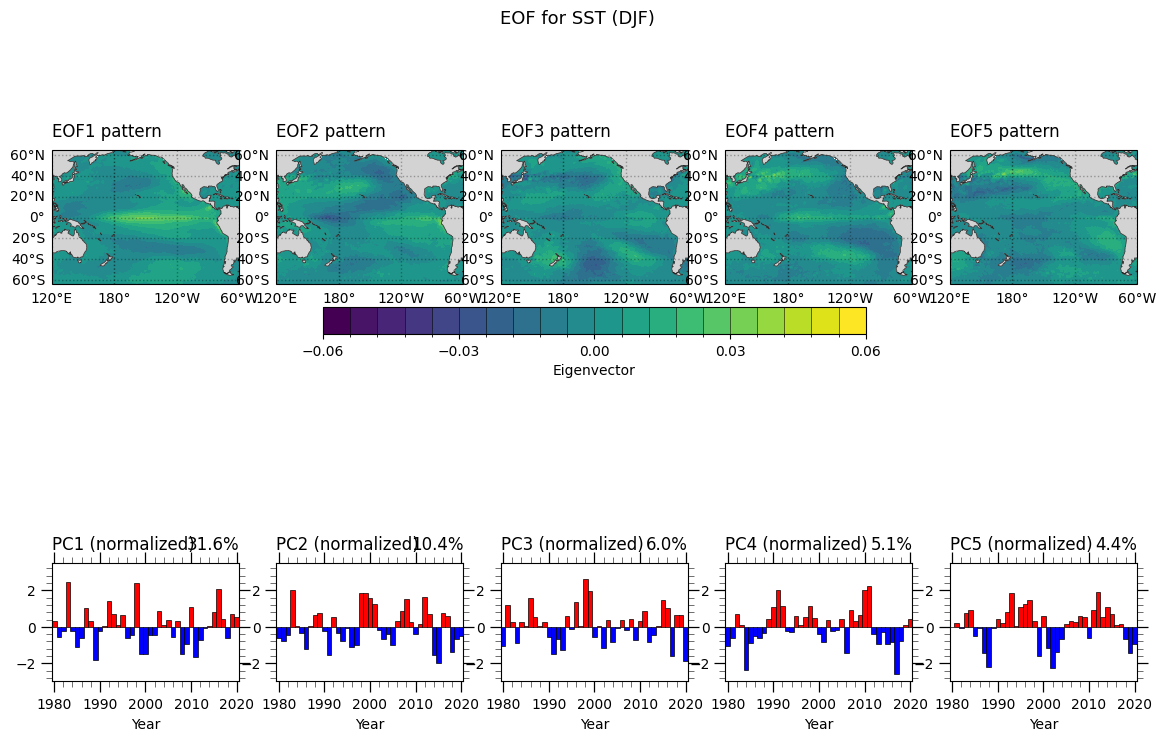

In [48]:
# Show the plot
fig = plt.figure(figsize=(14, 8))  
grid_new = fig.add_gridspec(ncols=5, nrows=4, hspace=0.4)

# Create the EOF plots (assuming each spans 2 rows)
print("Accessing grid location:", grid_new[0:2, 0]) 
ax1, fill1 = makefig(evec, 0, grid_new[0:2, 0])
ax2, fill2 = makefig(evec, 1, grid_new[0:2, 1])
ax3, fill3 = makefig(evec, 2, grid_new[0:2, 2])
ax4, fill4 = makefig(evec, 3, grid_new[0:2, 3])
ax5, fill5 = makefig(evec, 4, grid_new[0:2, 4])

# Create the bar charts in the bottom row
ax6 = make_bar_plot(pcs, 0, grid_new[3, 0])
ax7 = make_bar_plot(pcs, 1, grid_new[3, 1])
ax8 = make_bar_plot(pcs, 2, grid_new[3, 2])
ax9 = make_bar_plot(pcs, 3, grid_new[3, 3])
ax10 = make_bar_plot(pcs, 4, grid_new[3, 4])

# Add the colorbar 
fig.colorbar(fill2, 
             ax=[ax1, ax2, ax3, ax4, ax5],
             ticks=np.linspace(-0.06, 0.06, 5),
             drawedges=True,
             label='Eigenvector',
             orientation='horizontal',
             shrink=0.5,  
             pad=0.08,
             extendfrac='auto',
             extendrect=True)

fig.suptitle('EOF for SST (DJF)', fontsize=13, y=0.95) 
plt.show()  

The top row of maps illustrates the spatial patterns for the first five EOFs of sea surface temperature anomalies. These patterns highlight regions where variations in temperature are most coherent and contribute significantly to the overall variance in the dataset.

The bottom row shows the Principal Component time series for each EOF, which represent the temporal variability corresponding to each spatial pattern. The bars indicate the magnitude and sign of the PC for each year, with red representing positive values and blue indicating negative values.

The percentages in the PC time series titles (e.g., 31.6% for PC1) represent the proportion of the total variance in the dataset that is explained by that particular EOF mode.

In [51]:
# Specify the number of EOFs (modes) you want to calculate
neof_new= 10

# Calculate the EOFs specifying you want 10 of them
eofs_new = eofunc_eofs(xw_anm.data, neofs=neof_new, meta=True)
pcs_new = eofunc_pcs(xw_anm.data, npcs=neof_new, meta=True)


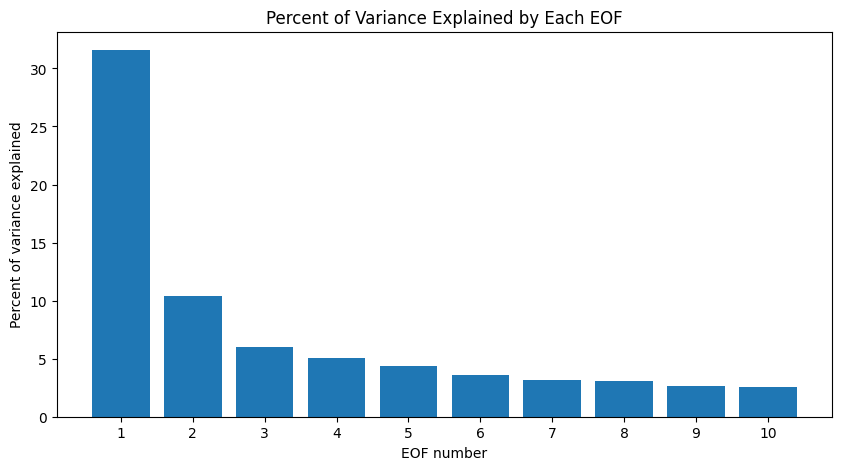

In [56]:
import matplotlib.pyplot as plt

# Assuming `eofs` is your EOF result and contains an attribute `varianceFraction`
variance_fraction_new = eofs_new.attrs['varianceFraction'][:10]  # Get the variance fraction for the first 10 EOFs

# Generate a range of EOF numbers for plotting (1-based indexing for display)
eof_numbers_new = range(1, 11)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(eof_numbers_new, variance_fraction_new * 100)  # Convert to percentage
plt.xlabel('EOF number')
plt.ylabel('Percent of variance explained')
plt.title('Percent of Variance Explained by Each EOF')
plt.xticks(eof_numbers_new)  # Set x-tick labels to correspond to EOF numbers
plt.show()

In [57]:
# Reconstruct the SST field using the first 5 EOFs
sst_reconstructed = sum(eofs[i, :, :] * pcs[:, i] for i in range(5))

# Calculate Pearson's correlation coefficient between the reconstructed and observed SST
# You need to ensure that 'sst' and 'sst_reconstructed' are aligned in time and space for this to work
correlation = xr.corr(sst_reconstructed, sst, dim='time')

# Plot the correlation
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
correlation.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

MemoryError: Unable to allocate 2.60 TiB for an array with shape (130, 181, 10, 516, 130, 181) and data type bool